# Imports

In [ ]:
!pip install nltk spacy
!python -m spacy download en_core_web_sm
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 110.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import networkx as nx
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_extraction
import re
import nltk
import spacy
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading PolitiFact Dataset

In [ ]:
# Load the news-user sharing relationships
news_user_df = pd.read_csv('/content/drive/MyDrive/PolitiFact/PolitiFactNewsUser.txt', sep='\t', header=None, names=['news_id', 'user_id', 'share_count'])
news_user_df.head()

,news_id,user_id,share_count
0,240,1,1
1,124,2,1
2,162,3,1
3,233,4,1
4,50,5,1


In [ ]:
news_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32791 entries, 0 to 32790
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   news_id      32791 non-null  int64
 1   user_id      32791 non-null  int64
 2   share_count  32791 non-null  int64
dtypes: int64(3)
memory usage: 768.7 KB


In [ ]:
# Load the user-user following relationships
user_user_df = pd.read_csv('/content/drive/MyDrive/PolitiFact/PolitiFactUserUser.txt', sep='\t', header=None, names=['follower_id', 'followee_id'])
user_user_df.head()

,follower_id,followee_id
0,507,1
1,1589,1
2,5307,1
3,11421,1
4,13267,1


In [ ]:
user_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574744 entries, 0 to 574743
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   follower_id  574744 non-null  int64
 1   followee_id  574744 non-null  int64
dtypes: int64(2)
memory usage: 8.8 MB


In [ ]:
# Load the news data
news_df = pd.read_csv('/content/drive/MyDrive/PolitiFact/News.txt', sep='\t', header=None, names=['news_id'])
news_df.head()

,news_id
0,PolitiFact_Real_1
1,PolitiFact_Real_2
2,PolitiFact_Real_3
3,PolitiFact_Real_4
4,PolitiFact_Real_5


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   news_id  240 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


In [ ]:
# Load the users data
user_df = pd.read_csv('/content/drive/MyDrive/PolitiFact/User.txt', sep='\t', header=None, names=['user_id'])
user_df.head()

,user_id
0,f4b46be21c2f553811cc8a73c4f0ff05
1,2ced3734cc9c164edd9a8f5fbebe976f
2,c84c4ea8ba67211f84781bdd64cafe43
3,1776d1765f5e82cd660d8d502f227402
4,4e8c2c300d96929895ce0edba915af16


In [ ]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23865 entries, 0 to 23864
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  23865 non-null  object
dtypes: object(1)
memory usage: 186.6+ KB


# **Data Statistics**

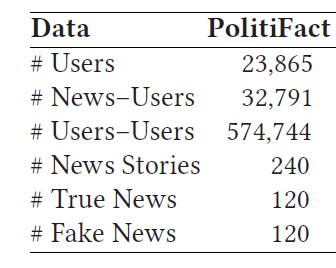

# Loading 'news' metadata

In [ ]:
# Define the directories for fake and real news
fake_news_dir = '/content/drive/MyDrive/PolitiFact/FakeNewsContent'
real_news_dir = '/content/drive/MyDrive/PolitiFact/RealNewsContent'

# Function to load all news files from a directory
def load_news_files(news_dir):
    news_data = []
    for filename in os.listdir(news_dir):
        if filename.endswith('.json'):
            with open(os.path.join(news_dir, filename)) as f:
                news = json.load(f)
                news['news_id'] = filename.split('-')[0].split('_')[-1]  # Add the news ID from the filename
                news_data.append(news)
    return news_data

# Load fake and real news files
fake_news_data = load_news_files(fake_news_dir)
real_news_data = load_news_files(real_news_dir)


In [ ]:
len(fake_news_data)

122

In [ ]:
len(real_news_data)

128

## Merging the 'fake' and 'real' news datasets into one dataframe

In [ ]:

# Convert the lists of dictionaries into Pandas DataFrames
fake_news_df = pd.DataFrame(fake_news_data)
real_news_df = pd.DataFrame(real_news_data)

# Add a label column: 0 for fake, 1 for real
fake_news_df['label'] = 0
real_news_df['label'] = 1

# Combine the two DataFrames
news_df = pd.concat([fake_news_df, real_news_df], ignore_index=True)
news_df.head()

,title,text,news_id,top_img,authors,keywords,meta_data,canonical_link,images,url,summary,movies,publish_date,source,label
0,Trump warns Russia over Jehovah’s Witnesses ba...,President Donald Trump has sent a strong messa...,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,cnnews3.com -&nbspcnnews3 Resources and Inform...,,24,,[],[],{'description': 'cnnews3.com is your first and...,,"[data:image/png;base64,iVBORw0KGgoAAAANSUhEUgA...",http://cnnews3.com/hiv-virus-detected-walmart-...,,[],None,http://cnnews3.com,0
2,“White People Have Suffered More In The Last 8...,"On Sunday, ex-Rep. Michelle Bachmann spoke wit...",110,http://uspoln.com/wp-content/uploads/2017/07/m...,[],[],"{'generator': 'WordPress 4.8.1', 'og': {'site_...",http://uspoln.com/2017/07/07/bachmann-white-pe...,[http://uspoln.com/wp-content/uploads/2017/07/...,http://uspoln.com/2017/07/07/bachmann-white-pe...,,[],{'$date': 1499385600000},http://uspoln.com,0
3,Home,,47,http://uspoln.com/wp-content/uploads/2017/07/B...,[],[],"{'og': {'locale': 'en_US', 'url': 'http://uspo...",http://uspoln.com/,[http://uspoln.com/wp-content/uploads/2017/07/...,http://uspoln.com/2017/03/17/tom-price-better-...,,[],{'$date': 1489708800000},http://uspoln.com,0
4,Barrack Obama will be on new 1 dollar bill 2017,The White House has approved the redesign of U...,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
news_df.tail()

,title,text,news_id,top_img,authors,keywords,meta_data,canonical_link,images,url,summary,movies,publish_date,source,label
245,Obama nominates ambassador to Cuba in long-sho...,Jeffrey DeLaurentis will serve as America's am...,69,http://static.politico.com/2d/3e/b3dc88fb4cf5b...,"[Jack Shafer, Nahal Toosi]",[],{'description': 'Jeffrey DeLaurentis is a care...,http://www.politico.com/story/2016/09/obama-no...,[https://static.politico.com/dims4/default/827...,http://politi.co/2dqcRvf,,[],{'$date': 1474996450000},http://politi.co,1
246,The Word Liberals are TERRIFIED Of – Eagle Rising,"Terrorism is terrorism, regardless of the sour...",83,http://eaglerising.com/wp-content/uploads/2016...,[View All Posts],[],{'description': 'It is not hard to say 'terror...,http://eaglerising.com/36863/terrorism-the-wor...,[http://constitution.com/wp-content/uploads/20...,http://eaglerising.com/36863/terrorism-the-wor...,,[],{'$date': 1474326152000},http://eaglerising.com,1
247,"Clint Eastwood Had Enough, Blows Up On Hillary...",7.6k SHARES Facebook Twitter\n\nHollywood lege...,84,http://freedomdaily.com/wp-content/uploads/201...,[],[],{'description': 'Clint Eastwood appears again!...,http://freedomdaily.com/clint-eastwood-had-eno...,[http://1csabj4ddrd61fgqez2e4nss.wpengine.netd...,http://freedomdaily.com/clint-eastwood-had-eno...,,[],{'$date': 1474394766000},http://freedomdaily.com,1
248,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,91,http://eaglerising.com/wp-content/uploads/2016...,[View All Posts],[],{'description': 'The possibility that CHAI dis...,http://eaglerising.com/36899/charity-clinton-f...,[http://constitution.com/wp-content/uploads/20...,http://eaglerising.com/36899/charity-clinton-f...,,[],{'$date': 1474416521000},http://eaglerising.com,1
249,Obama Claims It Will Be A Personal Insult If Y...,Obama Claims It Will Be A Personal Insult If Y...,112,http://rightwingnews.com/wp-content/uploads/20...,[Sonja Bochow],[],"{'googlebot': 'noimageindex', 'og': {'site_nam...",http://rightwingnews.com/top-news/obama-claims...,[http://rightwingnews.com/wp-content/uploads/w...,http://rightwingnews.com/top-news/obama-claims...,,[],{'$date': 1474245269000},http://rightwingnews.com,1


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           250 non-null    object
 1   text            250 non-null    object
 2   news_id         250 non-null    object
 3   top_img         217 non-null    object
 4   authors         217 non-null    object
 5   keywords        217 non-null    object
 6   meta_data       217 non-null    object
 7   canonical_link  217 non-null    object
 8   images          217 non-null    object
 9   url             217 non-null    object
 10  summary         217 non-null    object
 11  movies          217 non-null    object
 12  publish_date    170 non-null    object
 13  source          217 non-null    object
 14  label           250 non-null    int64 
dtypes: int64(1), object(14)
memory usage: 29.4+ KB


In [ ]:
news_df.isna().sum()

,0
title,0
text,0
news_id,0
top_img,33
authors,33
keywords,33
meta_data,33
canonical_link,33
images,33
url,33


In [ ]:
news_df.iloc[22]

,22
title,BREAKING: Johnny Depp Taken Into Custody By Se...
text,Johnny Depp made a big mistake when he threate...
news_id,103
top_img,http://snoopack.com/wp-content/uploads/2017/06...
authors,[]
keywords,[]
meta_data,{'ca_image': 'http://snoopack.com/wp-content/u...
canonical_link,http://snoopack.com/2017/06/24/breaking-johnny...
images,[http://snoopack.com/wp-content/uploads/2017/0...
url,http://snoopack.com/2017/06/24/breaking-johnny...


# Feature Engineering

(A) Features describing **news content**<br>
(B) Features describing **social network between users** and **user-news sharing relationship**<br>
(C) Linguistic Features<br>
(D) Sentimental Features


 We implement these one by one

 ### (A) Features describing **news content**

- Extracting **title-length** and **body-length** features

In [ ]:
news_df['title_length'] = news_df['title'].apply(len)
news_df['body_length'] = news_df['text'].apply(len)
news_df.head()

,title,text,news_id,top_img,authors,keywords,meta_data,canonical_link,images,url,summary,movies,publish_date,source,label,title_length,body_length
0,Trump warns Russia over Jehovah’s Witnesses ba...,President Donald Trump has sent a strong messa...,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,90,2468
1,cnnews3.com -&nbspcnnews3 Resources and Inform...,,24,,[],[],{'description': 'cnnews3.com is your first and...,,"[data:image/png;base64,iVBORw0KGgoAAAANSUhEUgA...",http://cnnews3.com/hiv-virus-detected-walmart-...,,[],None,http://cnnews3.com,0,52,0
2,“White People Have Suffered More In The Last 8...,"On Sunday, ex-Rep. Michelle Bachmann spoke wit...",110,http://uspoln.com/wp-content/uploads/2017/07/m...,[],[],"{'generator': 'WordPress 4.8.1', 'og': {'site_...",http://uspoln.com/2017/07/07/bachmann-white-pe...,[http://uspoln.com/wp-content/uploads/2017/07/...,http://uspoln.com/2017/07/07/bachmann-white-pe...,,[],{'$date': 1499385600000},http://uspoln.com,0,100,3635
3,Home,,47,http://uspoln.com/wp-content/uploads/2017/07/B...,[],[],"{'og': {'locale': 'en_US', 'url': 'http://uspo...",http://uspoln.com/,[http://uspoln.com/wp-content/uploads/2017/07/...,http://uspoln.com/2017/03/17/tom-price-better-...,,[],{'$date': 1489708800000},http://uspoln.com,0,4,0
4,Barrack Obama will be on new 1 dollar bill 2017,The White House has approved the redesign of U...,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,47,2532


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           250 non-null    object
 1   text            250 non-null    object
 2   news_id         250 non-null    object
 3   top_img         217 non-null    object
 4   authors         217 non-null    object
 5   keywords        217 non-null    object
 6   meta_data       217 non-null    object
 7   canonical_link  217 non-null    object
 8   images          217 non-null    object
 9   url             217 non-null    object
 10  summary         217 non-null    object
 11  movies          217 non-null    object
 12  publish_date    170 non-null    object
 13  source          217 non-null    object
 14  label           250 non-null    int64 
 15  title_length    250 non-null    int64 
 16  body_length     250 non-null    int64 
dtypes: int64(3), object(14)
memory usage: 33.3+ KB


- Extracting **day of the week** and **is_weekend** features-

In [ ]:
news_df['publish_date'] = news_df['publish_date'].apply(
    lambda x: pd.to_datetime(x['$date'], unit='ms') if isinstance(x, dict) and '$date' in x else pd.NaT
)

news_df['publish_date']

,publish_date
0,NaT
1,NaT
2,2017-07-07 00:00:00
3,2017-03-17 00:00:00
4,NaT
...,...
245,2016-09-27 17:14:10
246,2016-09-19 23:02:32
247,2016-09-20 18:06:06
248,2016-09-21 00:08:41


In [ ]:
news_df['day_of_week'] = news_df['publish_date'].dt.dayofweek
news_df['is_weekend'] = news_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           250 non-null    object        
 1   text            250 non-null    object        
 2   news_id         250 non-null    object        
 3   top_img         217 non-null    object        
 4   authors         217 non-null    object        
 5   keywords        217 non-null    object        
 6   meta_data       217 non-null    object        
 7   canonical_link  217 non-null    object        
 8   images          217 non-null    object        
 9   url             217 non-null    object        
 10  summary         217 non-null    object        
 11  movies          217 non-null    object        
 12  publish_date    170 non-null    datetime64[ns]
 13  source          217 non-null    object        
 14  label           250 non-null    int64         
 15  title_

###  (B) Features describing **social network between users** and **user-news sharing relationship**

- Total **number of unique users who shared the news**: Indicates the reach or popularity of a news article.
- Total **number of shares for a news** article: More number of shares indicates more popularity of the news
- **Average number of shares per user**: Indicate bot-like behavior or unusual activity.


In [ ]:
# Aggregate user engagement features for each news article
news_user_agg = news_user_df.groupby('news_id').agg(
    total_shares=('share_count', 'sum'),
    unique_users=('user_id', 'nunique'),
    avg_shares_per_user=('share_count', 'mean')
).reset_index()

news_df['news_id'] = news_df['news_id'].astype(int)

# Merge the user engagement features with the news_df (by news_id)
news_df = news_df.merge(news_user_agg, on='news_id', how='left')

# Fill NaN values with 0 (for news articles that were not shared)
news_df.fillna(0, inplace=True)
news_df.head()

<ipython-input-28-9dac89c3a252>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  news_df.fillna(0, inplace=True)


,title,text,news_id,top_img,authors,keywords,meta_data,canonical_link,images,url,...,publish_date,source,label,title_length,body_length,day_of_week,is_weekend,total_shares,unique_users,avg_shares_per_user
0,Trump warns Russia over Jehovah’s Witnesses ba...,President Donald Trump has sent a strong messa...,71,0,0,0,0,0,0,0,...,0,0,0,90,2468,0.0,0,27,27,1.000000
1,cnnews3.com -&nbspcnnews3 Resources and Inform...,,24,,[],[],{'description': 'cnnews3.com is your first and...,,"[data:image/png;base64,iVBORw0KGgoAAAANSUhEUgA...",http://cnnews3.com/hiv-virus-detected-walmart-...,...,0,http://cnnews3.com,0,52,0,0.0,0,13,12,1.083333
2,“White People Have Suffered More In The Last 8...,"On Sunday, ex-Rep. Michelle Bachmann spoke wit...",110,http://uspoln.com/wp-content/uploads/2017/07/m...,[],[],"{'generator': 'WordPress 4.8.1', 'og': {'site_...",http://uspoln.com/2017/07/07/bachmann-white-pe...,[http://uspoln.com/wp-content/uploads/2017/07/...,http://uspoln.com/2017/07/07/bachmann-white-pe...,...,2017-07-07 00:00:00,http://uspoln.com,0,100,3635,4.0,0,57,53,1.075472
3,Home,,47,http://uspoln.com/wp-content/uploads/2017/07/B...,[],[],"{'og': {'locale': 'en_US', 'url': 'http://uspo...",http://uspoln.com/,[http://uspoln.com/wp-content/uploads/2017/07/...,http://uspoln.com/2017/03/17/tom-price-better-...,...,2017-03-17 00:00:00,http://uspoln.com,0,4,0,4.0,0,6,5,1.200000
4,Barrack Obama will be on new 1 dollar bill 2017,The White House has approved the redesign of U...,23,0,0,0,0,0,0,0,...,0,0,0,47,2532,0.0,0,19,18,1.055556



- **Number of followers**of the users who shared the news: If someone with high number of followers share a piece of news, it is more likely to spread.
- **Number of followings** of the users who shared the news: If the person sharing a news is following a large number of people, this can give some indication of news virality as well.


In [ ]:
# Calculate the number of followers and followings for each user
followers_agg = user_user_df.groupby('followee_id').size().reset_index(name='num_followers')
followings_agg = user_user_df.groupby('follower_id').size().reset_index(name='num_followings')

# Merge the followers and followings information with the news-user relationship data
news_user_df = news_user_df.merge(followers_agg, left_on='user_id', right_on='followee_id', how='left')
news_user_df = news_user_df.merge(followings_agg, left_on='user_id', right_on='follower_id', how='left')

# Now, aggregate these new features by news_id (to create features at the news level)
user_influence_agg = news_user_df.groupby('news_id').agg(
    avg_followers=('num_followers', 'mean'),
    avg_followings=('num_followings', 'mean')
).reset_index()

# Merge the user influence features with the main news dataframe
news_df = news_df.merge(user_influence_agg, on='news_id', how='left')

# Again, fill NaN values with 0 (for news articles that were not shared)
news_df.fillna(0, inplace=True)

news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                250 non-null    object 
 1   text                 250 non-null    object 
 2   news_id              250 non-null    int64  
 3   top_img              250 non-null    object 
 4   authors              250 non-null    object 
 5   keywords             250 non-null    object 
 6   meta_data            250 non-null    object 
 7   canonical_link       250 non-null    object 
 8   images               250 non-null    object 
 9   url                  250 non-null    object 
 10  summary              250 non-null    object 
 11  movies               250 non-null    object 
 12  publish_date         250 non-null    object 
 13  source               250 non-null    object 
 14  label                250 non-null    int64  
 15  title_length         250 non-null    int


- **Centrality measures** (like degree centrality) of users who share the news gives how fast the news spreads.


In [ ]:
import networkx as nx

# Create a directed graph from the user-user relationships
G = nx.DiGraph()

# Add edges to the graph
for _, row in user_user_df.iterrows():
    G.add_edge(row['follower_id'], row['followee_id'])

# Compute degree centrality for all users
centrality = nx.degree_centrality(G)

# Map the centrality score to users in the news-user dataframe
news_user_df['centrality'] = news_user_df['user_id'].map(centrality)

# Aggregate the centrality score by news_id
centrality_agg = news_user_df.groupby('news_id').agg(
    avg_centrality=('centrality', 'mean')
).reset_index()

# Merge the centrality feature with the main news dataframe
news_df = news_df.merge(centrality_agg, on='news_id', how='left')

# Fill NaN values with 0
news_df.fillna(0, inplace=True)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                250 non-null    object 
 1   text                 250 non-null    object 
 2   news_id              250 non-null    int64  
 3   top_img              250 non-null    object 
 4   authors              250 non-null    object 
 5   keywords             250 non-null    object 
 6   meta_data            250 non-null    object 
 7   canonical_link       250 non-null    object 
 8   images               250 non-null    object 
 9   url                  250 non-null    object 
 10  summary              250 non-null    object 
 11  movies               250 non-null    object 
 12  publish_date         250 non-null    object 
 13  source               250 non-null    object 
 14  label                250 non-null    int64  
 15  title_length         250 non-null    int

### (C) Linguistic Features
- Word Count and Words per Sentence
- Negation Count
- Punctuation and Quote Count
- Part-of-speech (POS) Count
- Stop Words and Uppercase Words Count

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def extract_features(text):
    # Initial processing with spaCy
    doc = nlp(text)

    # Feature variables
    features = {}

    # 1. Basic Counts
    features['word_count'] = len([token.text for token in doc if token.is_alpha])  # Count words only
    features['words_per_sentence'] = features['word_count'] / max(1, len(list(doc.sents)))

    # 2. Negation count
    negations = ['no', 'not', "n't", 'never', 'none']
    features['negation_count'] = sum(1 for token in doc if token.text.lower() in negations)

    # 3. Punctuation and Quote Counts
    features['punctuation_count'] = sum(1 for token in doc if token.is_punct)
    features['quote_count'] = text.count('"') + text.count("'")

    # 4. POS Counts
    pos_counts = Counter([token.pos_ for token in doc])
    features['noun_count'] = pos_counts.get('NOUN', 0)
    features['proper_noun_count'] = pos_counts.get('PROPN', 0)
    features['determiner_count'] = pos_counts.get('DET', 0)
    features['adverb_count'] = pos_counts.get('ADV', 0)
    features['adjective_count'] = pos_counts.get('ADJ', 0)
    features['verb_3rd_person_singular_present_count'] = sum(1 for token in doc if token.tag_ == 'VBZ')  # 3rd person singular verbs

    # 5. Stop Words and Uppercase Words Count
    features['stop_word_count'] = sum(1 for token in doc if token.text.lower() in stop_words)
    features['uppercase_word_count'] = sum(1 for token in doc if token.is_alpha and token.text.isupper())

    return features

### (D) Sentimental Features

In [ ]:
# Initialize the VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to categorize sentiment
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    compound_score = sentiment_score['compound']

    # Categorizing based on compound score
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
# Initialize lists to store features for each row
title_features_list = []
text_features_list = []
titles = []
texts = []
title_sentiments = []  # New list to store title sentiments
text_sentiments = []  # New list to store text sentiments

# Iterate through each row in the DataFrame
for index, row in news_df.iterrows():
    # Extract features for the title and text
    title_features = extract_features(row['title'])
    text_features = extract_features(row['text'])
    title_sentiment = get_sentiment(row['title'])  # Get sentiment for title
    text_sentiment = get_sentiment(row['text'])  # Get sentiment for text

    # Append extracted features and sentiments to respective lists
    titles.append(row['title'])
    texts.append(row['text'])
    title_features_list.append(title_features)
    text_features_list.append(text_features)
    title_sentiments.append(title_sentiment)  # Append title sentiment
    text_sentiments.append(text_sentiment)  # Append text sentiment

# Convert lists of dictionaries into DataFrames
title_features_df = pd.DataFrame(title_features_list).add_prefix('title_')
text_features_df = pd.DataFrame(text_features_list).add_prefix('text_')

# original 'title' and 'text' columns and sentiments
original_text_df = pd.DataFrame({
    'title': titles,
    'text': texts,
    'title_sentiment': title_sentiments,  # Add title sentiment column
    'text_sentiment': text_sentiments  # Add text sentiment column
})

# Concatenate original text and feature DataFrames into a single DataFrame
linguistic_features_df = pd.concat([original_text_df, title_features_df, text_features_df], axis=1)

print(linguistic_features_df.head())

                                               title  \
0  Trump warns Russia over Jehovah’s Witnesses ba...   
1  cnnews3.com -&nbspcnnews3 Resources and Inform...   
2  “White People Have Suffered More In The Last 8...   
3                                               Home   
4    Barrack Obama will be on new 1 dollar bill 2017   

                                                text title_sentiment  \
0  President Donald Trump has sent a strong messa...        negative   
1                                                            neutral   
2  On Sunday, ex-Rep. Michelle Bachmann spoke wit...        negative   
3                                                            neutral   
4  The White House has approved the redesign of U...         neutral   

  text_sentiment  title_word_count  title_words_per_sentence  \
0       positive                16                      16.0   
1        neutral                 3                       3.0   
2       negative                17    

# Merged Features

In [ ]:
merged_df = pd.concat([news_df, linguistic_features_df], axis=1)
merged_df.head()

,title,text,news_id,top_img,authors,keywords,meta_data,canonical_link,images,url,...,text_punctuation_count,text_quote_count,text_noun_count,text_proper_noun_count,text_determiner_count,text_adverb_count,text_adjective_count,text_verb_3rd_person_singular_present_count,text_stop_word_count,text_uppercase_word_count
0,Trump warns Russia over Jehovah’s Witnesses ba...,President Donald Trump has sent a strong messa...,71,0,0,0,0,0,0,0,...,48,0,71,72,41,9,19,10,162,5
1,cnnews3.com -&nbspcnnews3 Resources and Inform...,,24,,[],[],{'description': 'cnnews3.com is your first and...,,"[data:image/png;base64,iVBORw0KGgoAAAANSUhEUgA...",http://cnnews3.com/hiv-virus-detected-walmart-...,...,0,0,0,0,0,0,0,0,0,0
2,“White People Have Suffered More In The Last 8...,"On Sunday, ex-Rep. Michelle Bachmann spoke wit...",110,http://uspoln.com/wp-content/uploads/2017/07/m...,[],[],"{'generator': 'WordPress 4.8.1', 'og': {'site_...",http://uspoln.com/2017/07/07/bachmann-white-pe...,[http://uspoln.com/wp-content/uploads/2017/07/...,http://uspoln.com/2017/07/07/bachmann-white-pe...,...,103,0,93,47,41,48,51,20,303,13
3,Home,,47,http://uspoln.com/wp-content/uploads/2017/07/B...,[],[],"{'og': {'locale': 'en_US', 'url': 'http://uspo...",http://uspoln.com/,[http://uspoln.com/wp-content/uploads/2017/07/...,http://uspoln.com/2017/03/17/tom-price-better-...,...,0,0,0,0,0,0,0,0,0,0
4,Barrack Obama will be on new 1 dollar bill 2017,The White House has approved the redesign of U...,23,0,0,0,0,0,0,0,...,82,0,66,79,45,16,21,19,171,1


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   title                                         250 non-null    object 
 1   text                                          250 non-null    object 
 2   news_id                                       250 non-null    int64  
 3   top_img                                       250 non-null    object 
 4   authors                                       250 non-null    object 
 5   keywords                                      250 non-null    object 
 6   meta_data                                     250 non-null    object 
 7   canonical_link                                250 non-null    object 
 8   images                                        250 non-null    object 
 9   url                                           250 non-null    obj

In [ ]:
# Initialize a single label encoder
label_encoder = LabelEncoder()

# Fit on combined data to ensure consistency
all_sentiments = merged_df['title_sentiment'].tolist() + merged_df['text_sentiment'].tolist()
label_encoder.fit(all_sentiments)

# Transform both columns using the same encoder
merged_df['title_sentiment_encoded'] = label_encoder.transform(merged_df['title_sentiment'])
merged_df['text_sentiment_encoded'] = label_encoder.transform(merged_df['text_sentiment'])

In [ ]:
merged_df = merged_df.select_dtypes(exclude=['object'])
merged_df = merged_df.drop(['news_id'], axis=1)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 39 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   label                                         250 non-null    int64  
 1   title_length                                  250 non-null    int64  
 2   body_length                                   250 non-null    int64  
 3   day_of_week                                   250 non-null    float64
 4   is_weekend                                    250 non-null    int64  
 5   total_shares                                  250 non-null    int64  
 6   unique_users                                  250 non-null    int64  
 7   avg_shares_per_user                           250 non-null    float64
 8   avg_followers                                 250 non-null    float64
 9   avg_followings                                250 non-null    flo

# Machine Learning Model and Performance

In [ ]:
#code from the lecture
def run_classification(X,y):

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

  precision_list=[]
  recall_list=[]
  f1_list=[]
  accuracy_list=[]
  auc_scores = []
  AVG_precision_scores = []
  cumulative_conf_matrix = np.zeros((2, 2))


  for tr_ind, tst_ind in skf.split(X,y):
      X_train = X[tr_ind]
      X_test = X[tst_ind]
      y_train = y[tr_ind]
      y_test = y[tst_ind]

      # clf = LogisticRegression(penalty='l2', class_weight='balanced', solver='lbfgs')
      clf = RandomForestClassifier(random_state=0,class_weight="balanced")
      clf.fit(X_train, y_train)

      # predict the labels on test dataset
      predictions = clf.predict(X_test)
      proba = clf.predict_proba(X_test)[:,1]


      #evaluation
      precision = metrics.precision_score(y_test, predictions)
      recall = metrics.recall_score(y_test, predictions)
      f1 = metrics.f1_score(y_test, predictions)
      accuracy = metrics.accuracy_score(y_test,predictions)
      conf_matrix= metrics.confusion_matrix(y_test,predictions)

      # Create a heatmap plot
      plt.figure(figsize=(6, 4))
      sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
      xticklabels=['Predicted Real', 'Predicted Fake'],
      yticklabels=['Actual Real', 'Actual Fake'])

      # Add labels and title
      plt.xlabel('Predicted Labels')
      plt.ylabel('True Labels')
      plt.title('Confusion Matrix')
      plt.show()

      cumulative_conf_matrix += conf_matrix


      precision_list.append(precision)
      recall_list.append(recall)
      f1_list.append(f1)
      accuracy_list.append(accuracy)
      auc_scores.append(roc_auc_score(y_test, proba))
      AVG_precision_scores.append(average_precision_score(y_test, proba))


  print("\n precision = ", round(np.mean(precision_list)*100,3),"\n",
        "\n recall = ",round(np.mean(recall_list)*100,3),"\n",
        "\n f1 = ",round(np.mean(f1_list)*100,3),"\n",
        "\n accuracy = ",round(np.mean(accuracy_list)*100,3),"\n",
        "\n AUROC = ", round(np.mean(auc_scores)*100,3),"\n",
        "\n Average Precision = ", round(np.mean(AVG_precision_scores)*100,3),"\n", )

# Plot the cumulative confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cumulative_conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False,
              xticklabels=['Predicted Real', 'Predicted Fake'],
              yticklabels=['Actual Real', 'Actual Fake'])

  # Add labels and title to the confusion matrix plot
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Cumulative Confusion Matrix (Across All Splits)')
  plt.show()


  # Plot the AUC scores for each fold
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, len(auc_scores) + 1), auc_scores, marker='o', linestyle='-', color='b', label='AUC Score')
  plt.xlabel('Fold')
  plt.ylabel('AUROC Score')
  plt.title('AUROC Scores Across Folds')
  plt.xticks(range(1, len(auc_scores) + 1))
  plt.grid(True)
  plt.show()

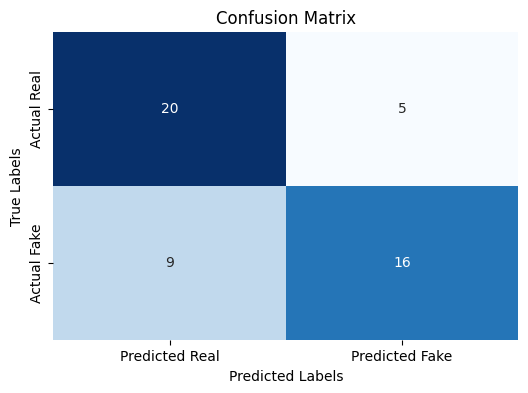

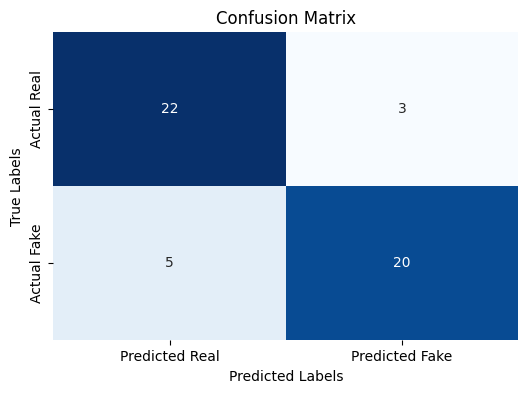

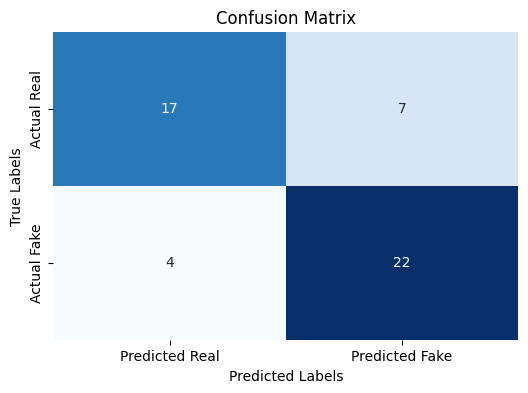

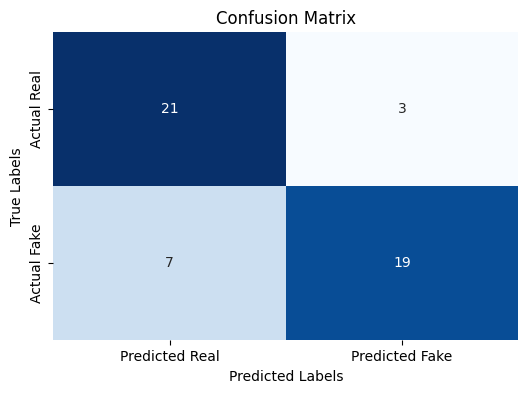

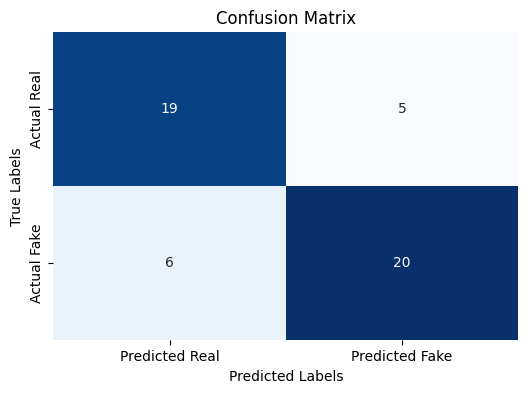


 precision =  81.075 
 
 recall =  75.723 
 
 f1 =  78.099 
 
 accuracy =  78.4 
 
 AUROC =  86.241 
 
 Average Precision =  87.478 



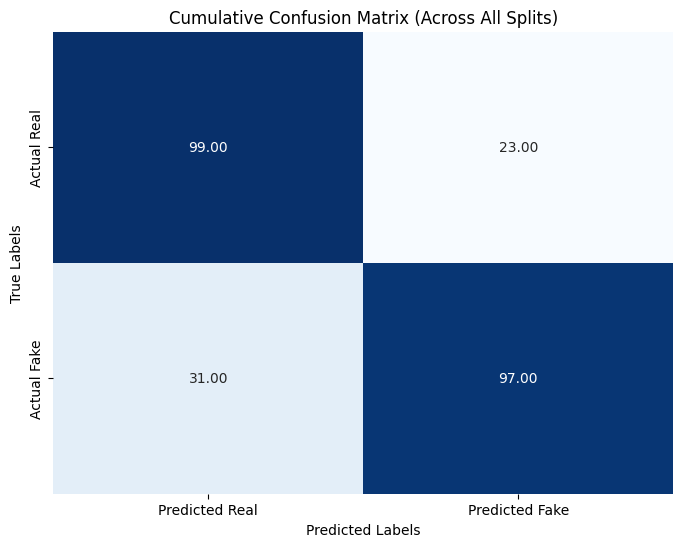

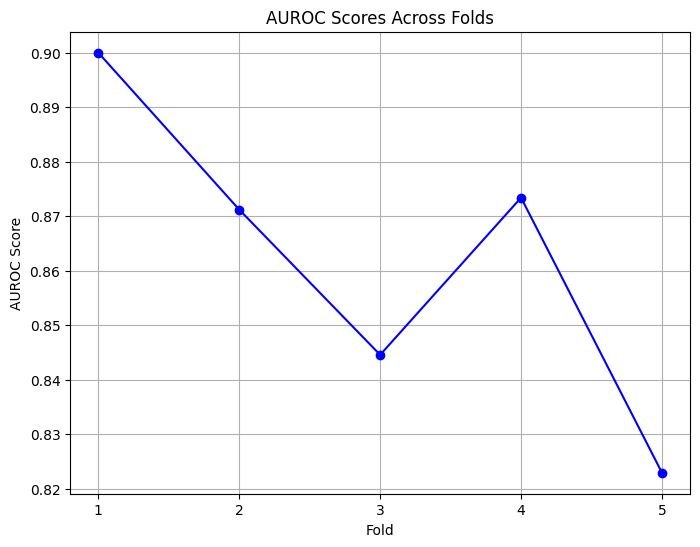

In [ ]:
X = merged_df.drop(columns=['label']).values
y = merged_df["label"].values


# Apply standard scaling to the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


run_classification(X,y)